# Calculating and plotting the order parameter of a lipid

This is a snippet demonstration of how to calculate the acyl chain order parameter (orientation of the C-H bond with respect to the bilayer normal) of a lipid. As it is not a full tutorial, we will not go into in-depth explanation of the analysis. Please see <a data-cite="piggot_calculation_2017" href="https://doi.org/10.1021/acs.jctc.7b00643">Piggot *et al.*, 2017</a> for more discussion on order parameters.

**Last executed:** Dec 29, 2020 with MDAnalysis 2.0.0-dev0


In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import GRO_MEMPROT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We load in a frame of POPE and POPG lipids.

In [2]:
u = mda.Universe(GRO_MEMPROT)

For this example we focus on POPE.

In [3]:
pope = u.select_atoms("resname POPE")

We examine the names of the carbon and hydrogen atoms to see how many, and which, tail carbons we should analyse.

In [4]:
last = pope.residues[-1].atoms
last.select_atoms("name C* H*").names

array(['HN1', 'HN2', 'HN3', 'C12', 'H12A', 'H12B', 'C11', 'H11A', 'H11B',
       'C1', 'HA', 'HB', 'C2', 'HS', 'C21', 'C22', 'H2R', 'H2S', 'C3',
       'HX', 'HY', 'C31', 'C32', 'H2X', 'H2Y', 'C23', 'H3R', 'H3S', 'C24',
       'H4R', 'H4S', 'C25', 'H5R', 'H5S', 'C26', 'H6R', 'H6S', 'C27',
       'H7R', 'H7S', 'C28', 'H8R', 'H8S', 'C29', 'H91', 'C210', 'H101',
       'C211', 'H11R', 'H11S', 'C212', 'H12R', 'H12S', 'C213', 'H13R',
       'H13S', 'C214', 'H14R', 'H14S', 'C215', 'H15R', 'H15S', 'C216',
       'H16R', 'H16S', 'C217', 'H17R', 'H17S', 'C218', 'H18R', 'H18S',
       'H18T', 'C33', 'H3X', 'H3Y', 'C34', 'H4X', 'H4Y', 'C35', 'H5X',
       'H5Y', 'C36', 'H6X', 'H6Y', 'C37', 'H7X', 'H7Y', 'C38', 'H8X',
       'H8Y', 'C39', 'H9X', 'H9Y', 'C310', 'H10X', 'H10Y', 'C311', 'H11X',
       'H11Y', 'C312', 'H12X', 'H12Y', 'C313', 'H13X', 'H13Y', 'C314',
       'H14X', 'H14Y', 'C315', 'H15X', 'H15Y', 'C316', 'H16X', 'H16Y',
       'H16Z'], dtype=object)

Tail carbons typically fit the pattern of C2-HR-HS and C3-HX-HY; as seen, so do the POPE molecules in this frame. From the names of the atoms, we can deduce that we should be looking at the tail carbons from 2 to 16.

We set up an output array, ``order``, to hold the order parameter for each tail carbon.

In [5]:
c_nums = np.arange(2, 16)
order = np.zeros(len(c_nums))

Below we iterate through each tail carbon number, select the hydrogens and carbons, and calculate the average bond parameter. In order to do this for a trajectory, you could repeat the below analysis by looping over each frame of a trajectory.

In [6]:
for i, n in enumerate(c_nums):
    c2 = pope.select_atoms(f"name C2{n}")
    hr = pope.select_atoms(f"name H{n}R")
    hs = pope.select_atoms(f"name H{n}S")
    c3 = pope.select_atoms(f"name C3{n}")
    hx = pope.select_atoms(f"name H{n}X")
    hy = pope.select_atoms(f"name H{n}Y")
    
    # we know that the pattern should be C2-HR-HS and C3-HX-HY
    # however, not all C2s and C3s have R/S/X/Ys attached
    # so we add the position vectors only if there are the
    # right numbers of Hs for each C
    ch1 = []
    ch2 = []
    
    if len(hr) == len(c2) and len(hs) == len(c2):
        cxyz = c2.positions
        ch1 += list(hr.positions - cxyz)
        ch2 += list(hs.positions - cxyz)
    
    if len(hx) == len(c3) and len(hy) == len(c3):
        cxyz = c3.positions
        ch1 += list(hx.positions - cxyz)
        ch2 += list(hy.positions - cxyz)
    
    # this gives us vectors from C to H
    vecs = np.concatenate([ch1, ch2], axis=0)
    norms = np.sum(vecs ** 2, axis=-1) ** 0.5
    
    # for this demonstration we take
    # the bilayer normal to be the z-axis, i.e.
    # only consider index 2 for the angles
    cos_theta = vecs[..., 2]/norms

    # equation 1 in Piggot et al., 2017
    S_ch = 0.5 * (3 * cos_theta**2 - 1).mean()
    order[i] = S_ch
    

Below we plot the negative $S_{CH}$, as is conventional.

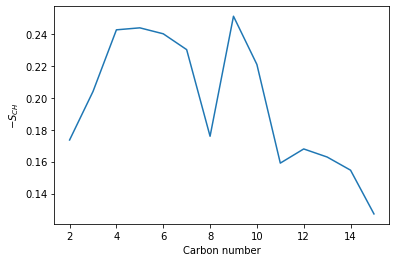

In [7]:
plt.plot(c_nums, -order)
plt.ylabel(r"$-S_{CH}$")
plt.xlabel("Carbon number")
plt.show()

## References

[1] Thomas&nbsp;J. Piggot, Jane&nbsp;R. Allison, Richard&nbsp;B. Sessions, and Jonathan&nbsp;W. Essex.
On the <span class="bibtex-protected">Calculation</span> of <span class="bibtex-protected">Acyl</span> <span class="bibtex-protected">Chain</span> <span class="bibtex-protected">Order</span> <span class="bibtex-protected">Parameters</span> from <span class="bibtex-protected">Lipid</span> <span class="bibtex-protected">Simulations</span>.
<em>Journal of Chemical Theory and Computation</em>, 13(11):5683–5696, November 2017.
Publisher: American Chemical Society.
URL: <a href="https://doi.org/10.1021/acs.jctc.7b00643">https://doi.org/10.1021/acs.jctc.7b00643</a>, <a href="https://doi.org/10.1021/acs.jctc.7b00643">doi:10.1021/acs.jctc.7b00643</a>.